# House Price Prediction 

Initializing important libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [83]:
#Import data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploratory Data Analysis

In [84]:
print("Training data shape:" , train.shape)
print("Test data shape:" , test.shape)

Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [85]:
#Check if there is any mismatch in the number of features between train and test
missing_cols = []
for column in train.loc[:, ~train.columns.isin(['SalePrice'])]:
    if column not in test.columns:
        missing_cols.append()
print("Number of features present in training data set that are not in test data:", len(missing_cols))       

missing_cols = []
for column in test.loc[:,~test.columns.isin(['Id'])]:
    if column not in train.columns:
        missing_cols.append()
print("Number of features present in test data set that are not in training data:", len(missing_cols))           


Number of features present in training data set that are not in test data: 0
Number of features present in test data set that are not in training data: 0


## Missing values

Plot percentage of missing data for both test and train sets. Note that it is important to deal with training and test sets during imputation SEPERATELY to avoid DATA LEAKAGE

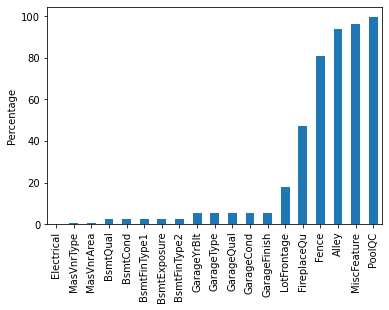

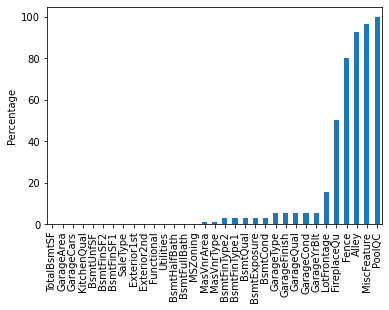

In [86]:
for df in [train,test]:
    missing = df.isnull().sum()
    total = missing[missing > 0]
    total.sort_values(inplace=True)
    percent = (total.sort_values(ascending = True)/len(df))*100
    fig, ax = plt.subplots()
    plt.ylabel('Percentage')
    percent.plot.bar()    

Both the training and test datasets have 4 features (Fence, Alley, MiscFeature and PoolQc) with more than 60% of missing data. As a rule of thumb, these features are removed from both sets.

In [87]:
#remove the 4 features
test = test.drop(['Fence','Alley','MiscFeature','PoolQC','Id'], axis =1) #also drop redundant Id label
train = train.drop(['Fence','Alley','MiscFeature','PoolQC','Id'], axis =1) #also drop redundant Id label

## Missing Values Imputation: Training data

In [88]:
#overview of the features with missing data
miss = train.isnull().sum()
miss = miss[miss>0]
print(miss)

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64


I look over the description file to study the meaning of these features.
For most features, values of NaN are probably there because the particular feature does not exist since it is rare that a garage or a basement actually exists but someone decided to not include it during data collection.
So a value of 0 or NA or none would be meaningful to replace for the features that represent basement, garage, masonry 
veneer type/area.


In [89]:
train.MasVnrType.fillna('NA', inplace=True)
train.MasVnrArea.fillna(0, inplace=True)
train.BsmtQual.fillna('NA', inplace=True)
train.BsmtCond.fillna('NA', inplace=True)
train.BsmtExposure.fillna('NA', inplace=True)
train.BsmtFinType1.fillna('NA', inplace=True)
train.BsmtFinType2.fillna('NA', inplace=True)
train.GarageType.fillna('NA', inplace=True)
train.GarageYrBlt.fillna(0, inplace=True) #Using 0 to represent that the garage was never built
train.GarageFinish.fillna('NA', inplace=True)
train.GarageQual.fillna('NA', inplace=True)
train.GarageCond.fillna('NA', inplace=True)

As per the description "LotFrontage" represents the linear feet of street connected to property. The best way to impute it is to replace it with the median street length in the particular neighbourhood of that house. 

"Electrical" has just 1 missing value and can be replaced with the mode.

In [90]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

'FireplaceQu' represents the quality of fireplace. Most likely, the missing values correspond to the fact that there is no fireplace. I first check this intuition.

In [91]:
print("A summary of the feature 'fireplace' for those houses where fireplace quality is missing :\n", train.Fireplaces[train.FireplaceQu.isnull()].describe())

A summary of the feature 'fireplace' for those houses where fireplace quality is missing :
 count    690.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Fireplaces, dtype: float64


Its clear that the "Fireplacequ" is missing only for those houses where "Fireplace" is absent. So replacing missing values in  Fireplacequ with NA.

In [92]:
train.FireplaceQu.fillna('NA', inplace=True)

In [93]:
#check if training data has any missing values left
temp = train.isnull().sum()
print("Number of missing values in training data:", len(temp[temp > 0]))

Number of missing values in training data: 0


## Missing Values Imputation: Test data

In [94]:
#overview of the features with missing data
miss = test.isnull().sum()
miss = miss[miss>0]
print(miss)

MSZoning          4
LotFrontage     227
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       16
MasVnrArea       15
BsmtQual         44
BsmtCond         45
BsmtExposure     44
BsmtFinType1     42
BsmtFinSF1        1
BsmtFinType2     42
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
FireplaceQu     730
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
SaleType          1
dtype: int64


Most features with missing values are the same as those we found earlier in train data. So applying similar imputation techniques for them should work.

In [95]:
#Imputation same as training data
test.MasVnrType.fillna('None', inplace=True)
test.MasVnrArea.fillna(0, inplace=True)
test.BsmtQual.fillna('NA', inplace=True)
test.BsmtCond.fillna('NA', inplace=True)
test.BsmtExposure.fillna('NA', inplace=True)
test.BsmtFinType1.fillna('NA', inplace=True)
test.BsmtFinType2.fillna('NA', inplace=True)
test.GarageType.fillna('NA', inplace=True)
test.GarageYrBlt.fillna(0, inplace=True) #Using 0 to represent that the garage was never built
test.GarageFinish.fillna('NA', inplace=True)
test.GarageQual.fillna('NA', inplace=True)
test.GarageCond.fillna('NA', inplace=True)
test.FireplaceQu.fillna('NA', inplace=True)

test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['Electrical'] = test['Electrical'].fillna(train['Electrical'].mode()[0])

The features with missing values that were not found in train data have very few (<10) missing values. Replacing these missing values with the corresponding mode value.

In [96]:
#Imputation of features not common with training data with median
miss = test.isnull().sum()
miss = miss[miss>0]
for var in miss.index:
    test[var] = test[var].fillna(test[var].mode()[0])
    
miss = test.isnull().sum()
print("Number of missing values in test data:", len(miss[miss>0]))

Number of missing values in test data: 0


### Splitting the data into Categorical and Quantitative

In [97]:
#Looking at the features description, MSSubClass is actually a categorical variable and not a quantitative variable. Converting:

train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

In [98]:
cat_train = train.select_dtypes(include=['object']).columns
cat_test = test.select_dtypes(include=['object']).columns

num_train = train.select_dtypes(exclude = ['object']).columns
num_test = test.select_dtypes(exclude = ['object']).columns

print("Numerical features : " + str(len(cat_train)))
print("Categorical features : " + str(len(num_train)))

feat_cat_train = train[cat_train]
feat_cat_test = test[cat_test]
feat_num_train = train[num_train]
feat_num_test = test[num_test]

Numerical features : 40
Categorical features : 36


# Feature Engineering

In [99]:
### Check the skew/kurtosis of the numerical features (TRAIN)

from scipy.stats import skew 
skewness = feat_num_train.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
OpenPorchSF       2.361912
LotFrontage       2.210685
SalePrice         1.880941
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
BsmtFullBath      0.595454
OverallQual       0.216721
MoSold            0.211835
BedroomAbvGr      0.211572
GarageArea        0.179796
YrSold            0.096170
FullBath          0.036524
GarageCars       -0.342197
YearRemodAdd     -0.503044
YearBuilt        -0.612831
GarageYrBlt      -3.865524
dtype: float64

It seems that a lot of features are highly skewed and should be transformed. I use log-transform on features that have a skew of more than 0.75 or less than -0.75 (rule of thumb).

In [100]:
## Transforming features in train data 

skewness = skewness[abs(skewness) > 0.75]
skewed_index = skewness.index

for i in skewed_index:
    feat_num_train[i] = np.log(feat_num_train[i]+1)

<ipython-input-100-717483c42219>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_num_train[i] = np.log(feat_num_train[i]+1)


In [101]:
## Transforming features in test data for the same features

for i in skewed_index[skewed_index != 'SalePrice']:
    feat_num_test[i] = np.log(feat_num_test[i]+1)

<ipython-input-101-9cf27188109d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_num_test[i] = np.log(feat_num_test[i]+1)


In [102]:
y = feat_num_train['SalePrice']

# One-hot Encoding Categorical Variables

The proper way to handle this issue is to fit a one-hot encoder on training dataset and then call transform function on both training and test datasets, separately, to get dummy variables. This ensures no mismatch between dummy variables in training and test datasets. It also guarantees no leakage issue.

In [103]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)
OH_train = pd.DataFrame(OH_encoder.fit_transform(feat_cat_train))
OH_test = pd.DataFrame(OH_encoder.transform(feat_cat_test))

# One-hot encoding removed index; put it back
OH_train.index = feat_cat_train.index
OH_test.index = feat_cat_test.index

# Feature Selection

Pearson's correlation only measures linear association, while Spearman's correlation can be used to check for any monotonic relationship. 
Creating a heatmap of features that have a Spearman correlation of more than 0.4:

<AxesSubplot:>

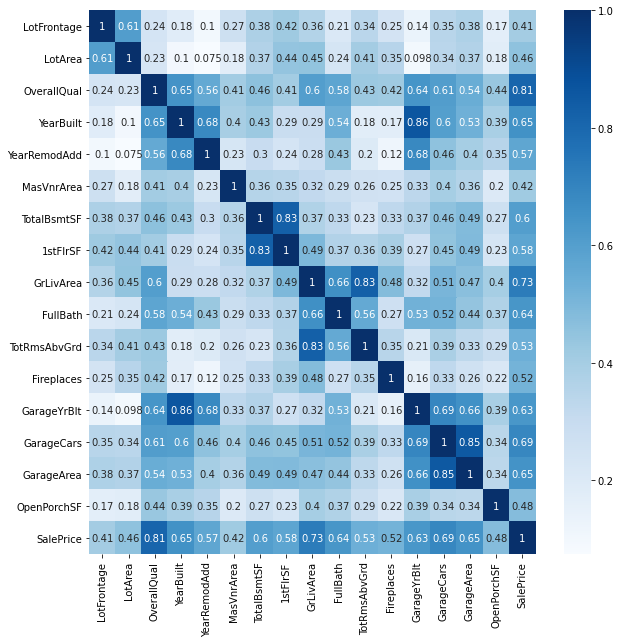

In [104]:
corr = feat_num_train.corr(method = 'spearman')
most_corr = corr.index[abs(corr["SalePrice"])>0.4]
plt.figure(figsize=(10,10))
sns.heatmap(feat_num_train[most_corr].corr(method = 'spearman'),cmap = "Blues", annot=True)

To avoid the problem of multicollinearity, features that are highly correlated with each other are dropped. 
Three sets of features highly correlated: "TotalBsmtSF, 1stFlrSF", "GarageArea, GarageCars" and "TotRmsAbvGrd, GrLivArea". 

Looking at the documentation, it is obvious that dropping any one feature from each group is fine since they represent essentially the same thing. We drop 1stFlrSF, GarageCars and TotRmsAbvGrd

In [105]:
feat_num_train = feat_num_train.drop(['1stFlrSF', 'GarageCars', 'TotRmsAbvGrd'], axis = 1)
feat_num_test = feat_num_test.drop(['1stFlrSF', 'GarageCars', 'TotRmsAbvGrd'], axis = 1)

Some of the features are related and should have relevant values. Ex. "HasPool" should be 0 if "PoolArea" is 0

In [106]:
#Train data
feat_num_train['haspool'] = feat_num_train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
feat_num_train['has2ndfloor'] = feat_num_train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
feat_num_train['hasgarage'] = feat_num_train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
feat_num_train['hasbsmt'] = feat_num_train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
feat_num_train['hasfireplace'] = feat_num_train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

#Test data
feat_num_test['haspool'] = feat_num_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
feat_num_test['has2ndfloor'] = feat_num_test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
feat_num_test['hasgarage'] = feat_num_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
feat_num_test['hasbsmt'] = feat_num_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
feat_num_test['hasfireplace'] = feat_num_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

Temporal Features: Features like 'Year-Built' and 'Garage Year Built' seem to be highly correlated. To avoid auto-correlation, 'YearRemodAdd' and 'GarageYrBlt' are dropped and only 'YearBuilt' is kept. 

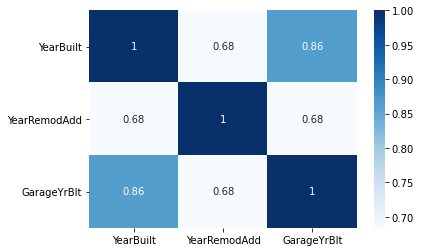

In [107]:
sns.heatmap(feat_num_train[['YearBuilt','YearRemodAdd','GarageYrBlt']].corr(method='spearman'), cmap="Blues", annot=True)
feat_num_train = feat_num_train.drop(['YearRemodAdd','GarageYrBlt'], axis = 1)
feat_num_test = feat_num_test.drop(['YearRemodAdd','GarageYrBlt'], axis = 1)

### Feature Selection: Wrapper Method

In [108]:
feat_num_train.drop(['SalePrice'],axis =1 ,inplace = True)

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0)) 
feature_sel_model.fit(feat_num_train, y)

selected_feat_lasso = feat_num_train.columns[(feature_sel_model.get_support())]

# let's print some stats
print('Total features: {}'.format((feat_num_train.shape[1])))
print('Selected features: {}'.format(len(selected_feat_lasso)))
print('The selected features are: {}'.format(selected_feat_lasso))

Total features: 35
Selected features: 20
The selected features are: Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'Fireplaces', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal', 'YrSold'],
      dtype='object')


### Feature Selection: Iterative

In [109]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor

rfe = RFE(estimator = DecisionTreeRegressor(),n_features_to_select=20)
rfe.fit(feat_num_train, y)

selected_feat_RFE = feat_num_train.columns[(rfe.get_support())]

# let's print some stats
print('Total features: {}'.format((feat_num_train.shape[1])))
print('Selected features: {}'.format(len(selected_feat_RFE)))
print('The selected features are: {}'.format(selected_feat_RFE))

Total features: 35
Selected features: 20
The selected features are: Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'HalfBath', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold', 'hasfireplace'],
      dtype='object')


### Final Features Selection: 
Analysing the features selected by the above 3 methods and going through the features description file, I select the following features:

In [110]:
final_feat_num = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt','OverallCond','TotalBsmtSF', 'FullBath','GarageArea', 'YrSold', 
              'OpenPorchSF','GrLivArea','FullBath']

feat_num_train = feat_num_train[final_feat_num]
feat_num_test = feat_num_test[final_feat_num]

### Combining Categorical and Numerical Data

In [111]:
X = pd.concat([OH_train,feat_num_train],axis = 1)
X_test = pd.concat([OH_test,feat_num_test], axis = 1)

# Modelling

In [112]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

In [113]:
#Create model scoring and kfolds functions

kfolds = KFold(n_splits=10)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

#### Setup models hyperparameters using a pipline

Pipelines are used so as to select the best hyper-parameters (out of the ones defined below).

In [114]:
# Hyper-paramaters to be used during tuning. The specific range for each hyper-parameter 
# was selected after carrying out several iterations.

alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_lasso = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [115]:
# Pipelines defined

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alphas_lasso, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))  
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [116]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, 
                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10)                             

### Calculating scores for each model

In [133]:
score_ridge = cv_rmse(ridge).mean()
print("Ridge: {:.4f} \n".format(score_ridge))

score_lasso = cv_rmse(lasso).mean()
print("Lasso: {:.4f} \n".format(score_lasso))

score_elastic = cv_rmse(elasticnet).mean()
print("Elastic Net: {:.4f} \n".format(score_elastic))

score_svr = cv_rmse(svr).mean()
print("SVR: {:.4f} \n".format(score_svr))

score_gbr = cv_rmse(gbr).mean()
print("GBR: {:.4f} \n".format(score_gbr))

Ridge: 0.1248 

Lasso: 0.1232 

Elastic Net: 0.1231 

SVR: 0.1238 

GBR: 0.1238 



In [119]:
#Fit the training data to each model

elastic_model_full_data = elasticnet.fit(X, y)
lasso_model_full_data = lasso.fit(X, y)
ridge_model_full_data = ridge.fit(X, y)
svr_model_full_data = svr.fit(X, y)
gbr_model_full_data = gbr.fit(X, y)

### Ensembling

All the models have performed in a similar fashion. While blending them all together, the weights are given as per the performance of each model.

In [120]:
def blend_models_predict(X):
    return ((0.22 * elastic_model_full_data.predict(X)) + \
            (0.22 * lasso_model_full_data.predict(X)) + \
            (0.15 * ridge_model_full_data.predict(X)) + \
            (0.21 * svr_model_full_data.predict(X)) + \
            (0.2 * gbr_model_full_data.predict(X)))

In [122]:
score_ensemble = rmse(y, blend_models_predict(X))
print("Ensemble Accuracy: {:.4f}".format(score_ensemble))

Ensemble Accuracy: 0.0917


In [135]:
scoring = pd.DataFrame({'Ridge': score_ridge, 
                     "Lasso": score_lasso,
                     "ElasticNet": score_elastic,
                     "SVR" : score_svr,
                     "GBR" : score_gbr,
                     "Ensemble": score_ensemble}, index = ['RMSE'])

Text(0, 0.5, 'RMSE Score')

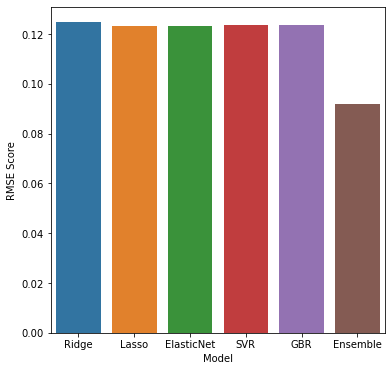

In [142]:
plt.figure(figsize=(6,6))
sns.barplot(data = scoring)
plt.xlabel("Model")
plt.ylabel("RMSE Score")

In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_test)))

In [ ]:
submission.to_csv("submission.csv", index=False)